## Import & cấu hình chung


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
)

# XGBoost:
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    print("XGBoost chưa sẵn sàng (không sao, có thể thêm sau).", e)

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 120


## Đọc dữ liệu & làm sạch 

In [83]:

DATA_PATH = "data/heart+disease/processed.cleveland.data"

cols = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach",
        "exang","oldpeak","slope","ca","thal","target"]

df = pd.read_csv(DATA_PATH, header=None, names=cols)

# đổi '?' -> NaN và ép kiểu số
df = df.replace("?", np.nan)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# nhị phân hóa nhãn: 0 = không bệnh, 1–4 = có bệnh
df["target"] = (df["target"] > 0).astype(int)

#print("Thiếu dữ liệu mỗi cột:\n", df.isna().sum())
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Thiếu dữ liệu mỗi cột:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


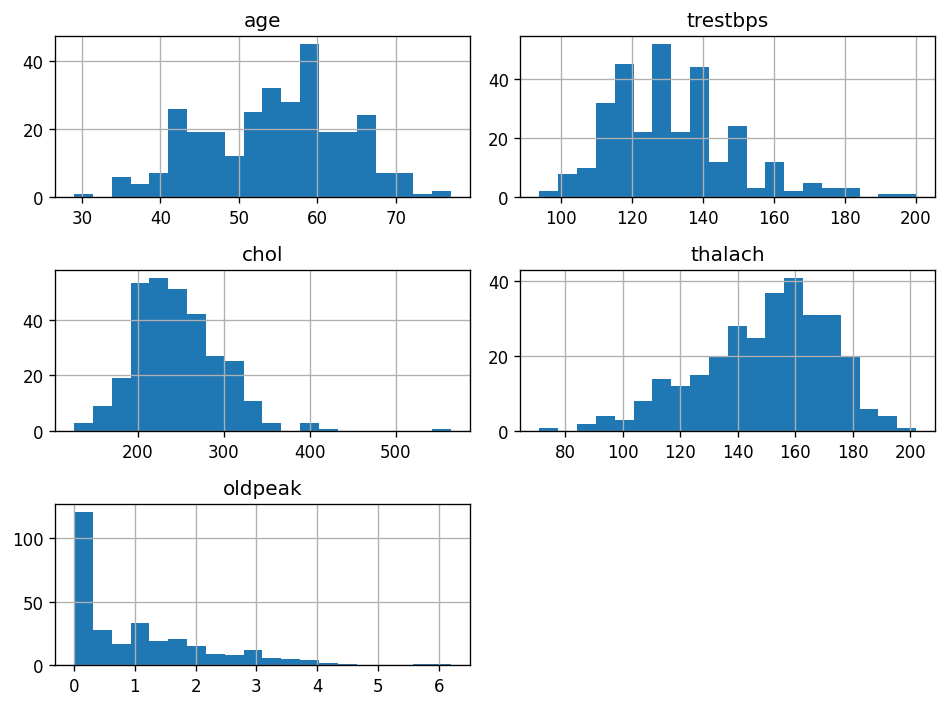

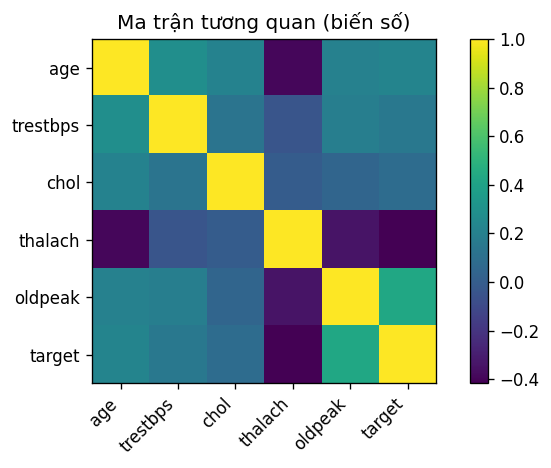

In [58]:
# Phân bố thiếu dữ liệu
print("Thiếu dữ liệu mỗi cột:\n", df.isna().sum())

# Phân phối một vài biến số
num_cols_quick = ["age","trestbps","chol","thalach","oldpeak"]
df[num_cols_quick].hist(bins=20, figsize=(8,6))
plt.tight_layout(); plt.show()

# Tương quan (chỉ cột số; nhớ đã ép numeric)
corr = df[num_cols_quick + ["target"]].corr()
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha="right")
plt.yticks(range(corr.shape[0]), corr.index)
plt.colorbar(); plt.title("Ma trận tương quan (biến số)"); plt.tight_layout(); plt.show()



Cleveland có ? ở ca, thal. Chuyển về NaN để SimpleImputer xử lý. Nhãn target được gom 0 vs 1–4 thành nhị phân (yêu cầu bài toán).

## Chia dữ liệu: train/val/test (70/15/15)

In [59]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

len(X_train), len(X_val), len(X_test), y.mean().round(3)


(212, 45, 46, np.float64(0.459))

Giải thích:

stratify=y giữ tỉ lệ lớp ở cả 3 tập → đánh giá công bằng.

Tách val riêng để chọn mô hình/siêu tham số không đụng vào test (giữ test “sạch”).

## Định nghĩa tiền xử lý (impute + scale + one-hot)

In [60]:
num_cols = ["age","trestbps","chol","thalach","oldpeak","ca"]
cat_cols = ["sex","cp","fbs","restecg","exang","slope","thal"]

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])


Giải thích:

Số: điền thiếu median (robust trước outlier) + chuẩn hoá để LR/SVM học tốt.

Danh mục: điền mode + one-hot (không gán thứ bậc giả).

ColumnTransformer: áp dụng đúng bước cho từng nhóm cột.

## Hàm huấn luyện & đánh giá (dùng chung cho mọi mô hình)

In [61]:
def fit_eval(model, name, X_train, y_train, X_val, y_val, X_test, y_test):
    pipe = Pipeline(steps=[("pre", preprocess), ("clf", model)])
    pipe.fit(X_train, y_train)

    # Validation để chọn mô hình/siêu tham số
    val_proba = pipe.predict_proba(X_val)[:,1]
    val_auc  = roc_auc_score(y_val, val_proba)

    # Đánh giá trên test (giữ nguyên ngưỡng 0.5 trước)
    test_proba = pipe.predict_proba(X_test)[:,1]
    test_pred  = (test_proba >= 0.5).astype(int)

    metrics = {
        "Model": name,
        "Val AUC": roc_auc_score(y_val, val_proba),
        "Test AUC": roc_auc_score(y_test, test_proba),
        "Accuracy": accuracy_score(y_test, test_pred),
        "Precision": precision_score(y_test, test_pred, zero_division=0),
        "Recall": recall_score(y_test, test_pred, zero_division=0),
        "F1": f1_score(y_test, test_pred, zero_division=0),
        "pipe": pipe,            # trả cả pipeline để dùng tiếp
        "test_proba": test_proba # để vẽ ROC/PR
    }
    return metrics


Giải thích: ta luôn đặt tiền xử lý trong Pipeline để tránh mọi lỗi NaN/scale/encode và đảm bảo suy luận sau này chỉ cần load pipeline.

## Train từng mô hình & giải thích

# Logistic Regression (LR)

In [62]:
lr = LogisticRegression(
    max_iter=2000,     # đủ số vòng lặp để hội tụ
    class_weight="balanced",  # cân bằng lớp nếu lệch
    C=1.0              # regularization (1/C = độ phạt)
)
res_lr = fit_eval(lr, "LogisticRegression", X_train, y_train, X_val, y_val, X_test, y_test)
res_lr


{'Model': 'LogisticRegression',
 'Val AUC': 0.9047619047619047,
 'Test AUC': 0.9485714285714285,
 'Accuracy': 0.9130434782608695,
 'Precision': 0.8695652173913043,
 'Recall': 0.9523809523809523,
 'F1': 0.9090909090909091,
 'pipe': Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['age', 'trestbps', 'chol',
                                                    'thalach', 'oldpeak',
                                                    'ca']),
                                                  ('cat',
                                                   Pipeline(steps=[

Giải thích: LR là baseline minh bạch. C lớn → ít phạt, dễ overfit; C nhỏ → nhiều phạt, đơn giản hơn. Dùng class_weight='balanced' nếu tỉ lệ lớp hơi lệch.

# Decision Tree (DT)


In [63]:
dt = DecisionTreeClassifier(
    criterion="gini",  
    max_depth=4,       # giới hạn để giảm overfit
    min_samples_split=10,
    random_state=42
)
res_dt = fit_eval(dt, "DecisionTree", X_train, y_train, X_val, y_val, X_test, y_test)
res_dt


{'Model': 'DecisionTree',
 'Val AUC': 0.7857142857142857,
 'Test AUC': 0.7666666666666666,
 'Accuracy': 0.7608695652173914,
 'Precision': 0.7272727272727273,
 'Recall': 0.7619047619047619,
 'F1': 0.7441860465116279,
 'pipe': Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['age', 'trestbps', 'chol',
                                                    'thalach', 'oldpeak',
                                                    'ca']),
                                                  ('cat',
                                                   Pipeline(steps=[('impu

Giải thích: Cây đơn lẻ dễ overfit; giới hạn max_depth và min_samples_split để ổn định hơn. Dễ trực quan hoá logic phân chia.

# Random Forest (RF)

In [64]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,      # để cây sâu vừa phải nhờ các cơ chế random
    max_features="sqrt", # số đặc trưng thử mỗi split
    random_state=42,
    class_weight="balanced"
)
res_rf = fit_eval(rf, "RandomForest", X_train, y_train, X_val, y_val, X_test, y_test)
res_rf


{'Model': 'RandomForest',
 'Val AUC': 0.9007936507936508,
 'Test AUC': 0.9466666666666667,
 'Accuracy': 0.8695652173913043,
 'Precision': 0.8260869565217391,
 'Recall': 0.9047619047619048,
 'F1': 0.8636363636363636,
 'pipe': Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['age', 'trestbps', 'chol',
                                                    'thalach', 'oldpeak',
                                                    'ca']),
                                                  ('cat',
                                                   Pipeline(steps=[('impu

Giải thích: RF = nhiều cây độc lập (bagging) → ổn định, ít overfit hơn DT. Có feature importance để xem đặc trưng nào quan trọng.

# SVM (SVC với RBF)

In [65]:
svc = SVC(
    kernel="rbf", C=1.0, gamma="scale",
    probability=True,    # để có predict_proba phục vụ AUC/ROC
    random_state=42
)
res_svc = fit_eval(svc, "SVC_RBF", X_train, y_train, X_val, y_val, X_test, y_test)
res_svc


{'Model': 'SVC_RBF',
 'Val AUC': 0.9285714285714286,
 'Test AUC': 0.9352380952380952,
 'Accuracy': 0.8695652173913043,
 'Precision': 0.8260869565217391,
 'Recall': 0.9047619047619048,
 'F1': 0.8636363636363636,
 'pipe': Pipeline(steps=[('pre',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['age', 'trestbps', 'chol',
                                                    'thalach', 'oldpeak',
                                                    'ca']),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',

Giải thích: SVM mạnh với dữ liệu vừa/nhỏ, đặc biệt khi mối quan hệ phi tuyến. probability=True để tính AUC/ROC. Có thể tuning C (độ phạt) và gamma.

# XGBoost

In [66]:
if HAS_XGB:
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        random_state=42
    )
    res_xgb = fit_eval(xgb, "XGBoost", X_train, y_train, X_val, y_val, X_test, y_test)
    res_xgb
else:
    res_xgb = None


Giải thích: XGBoost học theo chuỗi để sửa sai số còn lại → thường cho hiệu năng cao trên dữ liệu bảng. Các tham số trên là khởi tạo an toàn.


## AUC

In [67]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1) Logistic Regression
pipe_lr = Pipeline([("pre", preprocess), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))])
grid_lr = {"clf__C": [0.1, 0.5, 1.0, 3.0]}
gs_lr = GridSearchCV(pipe_lr, grid_lr, scoring="roc_auc", cv=skf, n_jobs=-1)
gs_lr.fit(X_train, y_train)
print("[LR] best params:", gs_lr.best_params_, "best cv AUC:", round(gs_lr.best_score_, 4))

# 2) SVC (RBF)
pipe_svc = Pipeline([("pre", preprocess), ("clf", SVC(kernel="rbf", probability=True, random_state=42))])
grid_svc = {"clf__C": [0.5, 1.0, 3.0], "clf__gamma": ["scale", 0.1, 0.01]}
gs_svc = GridSearchCV(pipe_svc, grid_svc, scoring="roc_auc", cv=skf, n_jobs=-1)
gs_svc.fit(X_train, y_train)
print("[SVC] best params:", gs_svc.best_params_, "best cv AUC:", round(gs_svc.best_score_, 4))

# 3) RandomForest
pipe_rf = Pipeline([("pre", preprocess), ("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))])
grid_rf = {
    "clf__n_estimators": [300, 400],
    "clf__max_features": ["sqrt", "log2"],
    "clf__max_depth": [None, 8, 12]
}
gs_rf = GridSearchCV(pipe_rf, grid_rf, scoring="roc_auc", cv=skf, n_jobs=-1)
gs_rf.fit(X_train, y_train)
print("[RF] best params:", gs_rf.best_params_, "best cv AUC:", round(gs_rf.best_score_, 4))


[LR] best params: {'clf__C': 0.1} best cv AUC: 0.9089
[SVC] best params: {'clf__C': 1.0, 'clf__gamma': 0.01} best cv AUC: 0.9064
[RF] best params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 400} best cv AUC: 0.905


Chọn mô hình: LogisticRegression | best CV AUC: 0.9089 | params: {'clf__C': 0.1}
Ngưỡng cố định (tối ưu trên VAL, chọn bằng model train-only): 0.376
Test AUC: 0.939047619047619
Accuracy: 0.782608695652174
Precision: 0.6896551724137931
Recall: 0.9523809523809523
F1: 0.8


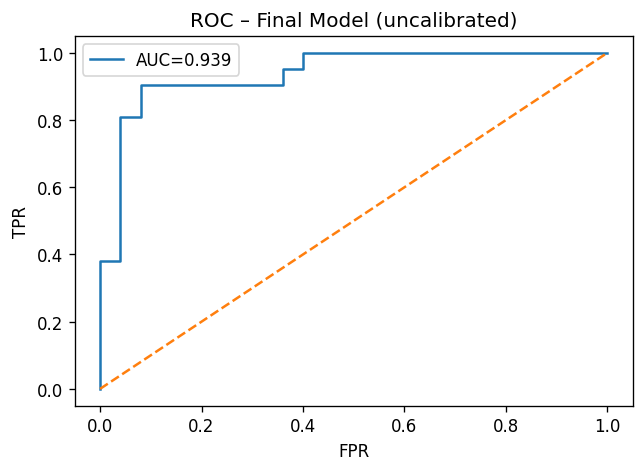

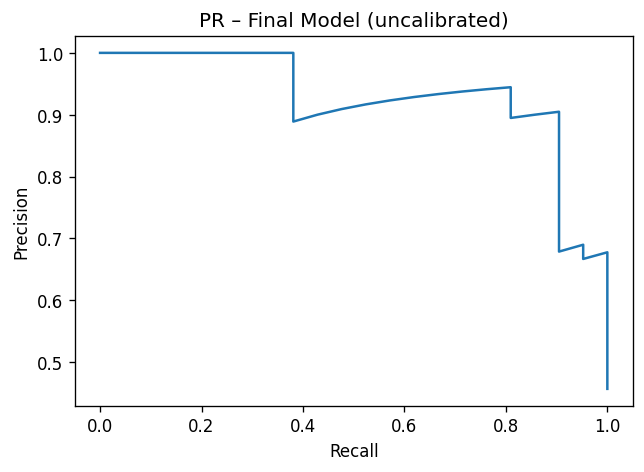

Test AUC: 0.939047619047619
Accuracy: 0.782608695652174
Precision: 0.6896551724137931
Recall: 0.9523809523809523
F1: 0.8


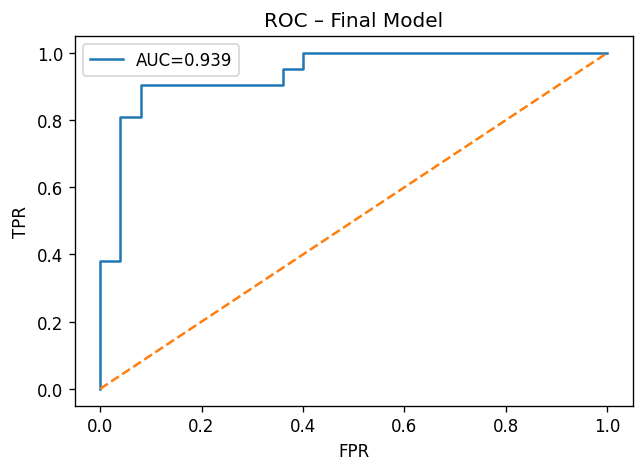

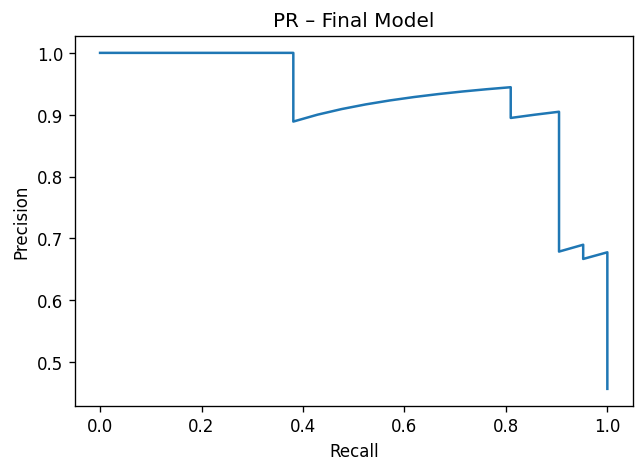

In [68]:
X_trainval = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_trainval = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# Chọn mô hình tốt nhất từ GridSearch (theo CV AUC) ===
gs_candidates = [gs_lr, gs_svc, gs_rf]
gs_best = max(gs_candidates, key=lambda g: g.best_score_)
print("Chọn mô hình:", type(gs_best.best_estimator_.named_steps["clf"]).__name__,
      "| best CV AUC:", round(gs_best.best_score_, 4),
      "| params:", gs_best.best_params_)


# 1) Dùng mô hình đã refit trên X_train (gs_best.best_estimator_) để chọn ngưỡng trên VALIDATION
best_on_train = gs_best.best_estimator_  # đã được GridSearchCV refit trên X_train
val_proba_for_threshold = best_on_train.predict_proba(X_val)[:, 1]

def pick_threshold_for_best_f1(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1s = 2*prec*rec/(prec+rec+1e-12)
    i = np.nanargmax(f1s)
    return max(thr[i-1], 0.0) if i>0 and i-1 < len(thr) else 0.5

opt_th_val = pick_threshold_for_best_f1(y_val.values, val_proba_for_threshold)
print("Ngưỡng cố định (tối ưu trên VAL, chọn bằng model train-only):", round(opt_th_val, 3))

# 2) Clone mô hình và FIT LẠI trên TRAIN+VAL (không dùng VAL để chọn ngưỡng nữa)
from sklearn.base import clone
final_model = clone(best_on_train)
final_model.fit(X_trainval, y_trainval)

# Đánh giá trên TEST với ngưỡng cố định từ VAL
test_proba_final = final_model.predict_proba(X_test)[:,1]
test_pred_final = (test_proba_final >= opt_th_val).astype(int)

print("Test AUC:", roc_auc_score(y_test, test_proba_final))
print("Accuracy:", accuracy_score(y_test, test_pred_final))
print("Precision:", precision_score(y_test, test_pred_final, zero_division=0))
print("Recall:", recall_score(y_test, test_pred_final, zero_division=0))
print("F1:", f1_score(y_test, test_pred_final, zero_division=0))

# ROC & PR (final_model, uncalibrated)
fpr, tpr, _ = roc_curve(y_test, test_proba_final)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, test_proba_final):.3f}")
plt.plot([0,1],[0,1],"--"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC – Final Model (uncalibrated)"); plt.legend(); plt.show()

prec, rec, _ = precision_recall_curve(y_test, test_proba_final)
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR – Final Model (uncalibrated)")
plt.show()

# ĐÁNH GIÁ TRÊN TEST với ngưỡng cố định ---
test_proba_final = final_model.predict_proba(X_test)[:,1]
test_pred_final = (test_proba_final >= opt_th_val).astype(int)

print("Test AUC:", roc_auc_score(y_test, test_proba_final))
print("Accuracy:", accuracy_score(y_test, test_pred_final))
print("Precision:", precision_score(y_test, test_pred_final, zero_division=0))
print("Recall:", recall_score(y_test, test_pred_final, zero_division=0))
print("F1:", f1_score(y_test, test_pred_final, zero_division=0))

# ROC/PR của mô hình final
fpr, tpr, _ = roc_curve(y_test, test_proba_final)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, test_proba_final):.3f}")
plt.plot([0,1],[0,1],"--"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC – Final Model"); plt.legend(); plt.show()

prec, rec, _ = precision_recall_curve(y_test, test_proba_final)
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR – Final Model")
plt.show()


Brier score (test): 0.1011


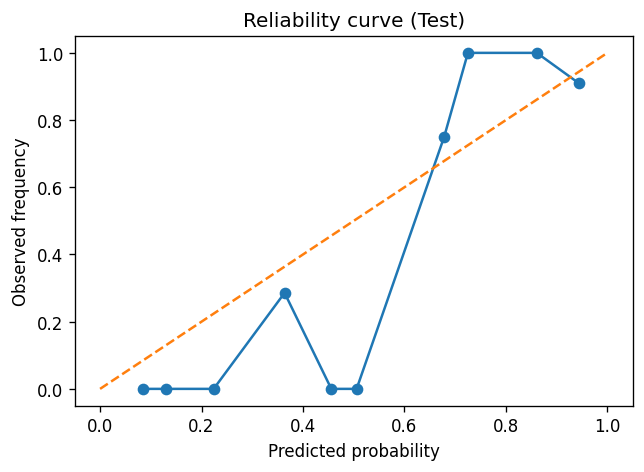

In [69]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

# Đánh giá calibration trên test với xác suất của final_model
y_score = test_proba_final
print("Brier score (test):", round(brier_score_loss(y_test, y_score), 4))

prob_true, prob_pred = calibration_curve(y_test, y_score, n_bins=10)
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Reliability curve (Test)")
plt.show()


In [70]:
# độ tin cậy
rng = np.random.default_rng(42)

def bootstrap_ci_metric(metric_fn, y_true, y_score_or_pred, kind="proba", B=2000):
    vals = []
    y = y_true.values if hasattr(y_true, "values") else np.asarray(y_true)
    p = np.asarray(y_score_or_pred)
    n = len(y)
    for _ in range(B):
        idx = rng.integers(0, n, n)
        if kind == "proba":
            vals.append(metric_fn(y[idx], p[idx]))
        else:  # kind == "label"
            vals.append(metric_fn(y[idx], p[idx]))
    return np.percentile(vals, [2.5, 97.5])

auc_ci = bootstrap_ci_metric(roc_auc_score, y_test, test_proba_final, kind="proba", B=2000)
f1_ci  = bootstrap_ci_metric(f1_score, y_test, test_pred_final, kind="label", B=2000)
print("AUC 95% CI:", [round(x,4) for x in auc_ci])
print("F1  95% CI:", [round(x,4) for x in f1_ci])


AUC 95% CI: [np.float64(0.8591), np.float64(0.9981)]
F1  95% CI: [np.float64(0.6538), np.float64(0.9091)]


## Tổng hợp & trực quan hoá


# Bảng so sánh kết quả

In [71]:
rows = [res_lr, res_dt, res_rf, res_svc] + ([res_xgb] if res_xgb else [])
summary = pd.DataFrame([{
    "Model": r["Model"],
    "Val AUC": round(r["Val AUC"],3),
    "Test AUC": round(r["Test AUC"],3),
    "Accuracy": round(r["Accuracy"],3),
    "Precision": round(r["Precision"],3),
    "Recall": round(r["Recall"],3),
    "F1": round(r["F1"],3),
} for r in rows]).sort_values("Val AUC", ascending=False).reset_index(drop=True)
summary


,Model,Val AUC,Test AUC,Accuracy,Precision,Recall,F1
0,SVC_RBF,0.929,0.935,0.870,0.826,0.905,0.864
1,LogisticRegression,0.905,0.949,0.913,0.870,0.952,0.909
2,RandomForest,0.901,0.947,0.870,0.826,0.905,0.864
3,XGBoost,0.893,0.928,0.826,0.810,0.810,0.810
4,DecisionTree,0.786,0.767,0.761,0.727,0.762,0.744


Giải thích: chọn mô hình tốt nhất theo Val AUC để tránh “nhìn trộm” test. Sau đó xem Test AUC để xác nhận khả năng tổng quát.

# Vẽ ROC & PR cho mô hình tốt nhấtVẽ ROC & PR cho mô hình tốt nhất

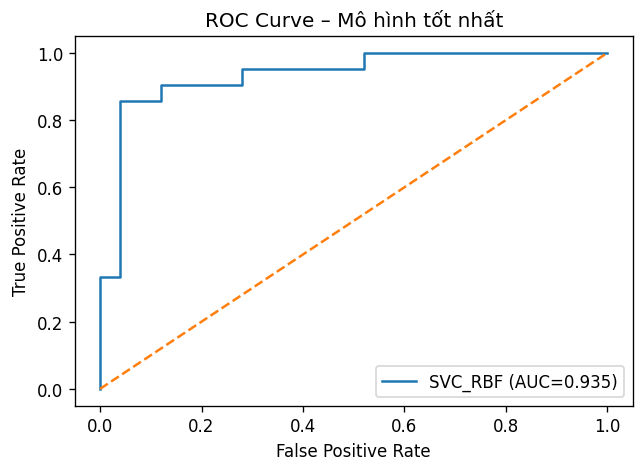

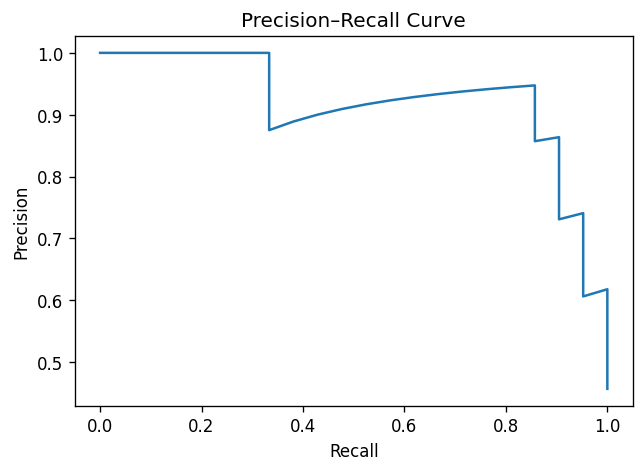

In [72]:
best = max(rows, key=lambda r: r["Val AUC"])
best_name = best["Model"]; best_pipe = best["pipe"]

# ROC
y_score = best["test_proba"]; y_true = y_test.values
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.plot(fpr, tpr, label=f"{best_name} (AUC={roc_auc_score(y_true,y_score):.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Mô hình tốt nhất"); plt.legend(); plt.show()

# PR
prec, rec, thr = precision_recall_curve(y_true, y_score)
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve")
plt.show()


Giải thích:

ROC: càng xa đường chéo càng tốt; AUC cao → phân biệt tốt 2 lớp.

PR: hữu ích khi ưu tiên không bỏ sót ca bệnh (Recall) hoặc giảm cảnh báo giả (Precision).

# (Tuỳ chọn) Tầm quan trọng đặc trưng

# Random Forest

In [73]:
if best_name == "RandomForest":
    # Lấy tên cột sau one-hot
    ohe = best_pipe.named_steps["pre"].named_transformers_["cat"].named_steps["onehot"]
    ohe_names = ohe.get_feature_names_out(cat_cols)
    feature_names = np.r_[num_cols, ohe_names]

    importances = best_pipe.named_steps["clf"].feature_importances_
    idx = np.argsort(importances)[::-1][:15]
    plt.barh(range(len(idx)), importances[idx][::-1])
    plt.yticks(range(len(idx)), feature_names[idx][::-1])
    plt.title("Top-15 Feature Importance (RandomForest)")
    plt.tight_layout(); plt.show()


# XGBoost + SHAP (nâng cao)

In [74]:
if HAS_XGB and best_name == "XGBoost":
    import shap
    # lấy ma trận đặc trưng sau preprocess
    X_test_trans = best_pipe.named_steps["pre"].transform(X_test)
    clf = best_pipe.named_steps["clf"]
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer(X_test_trans)
    shap.summary_plot(shap_values, X_test_trans, show=False)
    plt.title("SHAP Summary – XGBoost"); plt.show()


Giải thích:

RF feature importance: cho biết đặc trưng nào hay được dùng để tách dữ liệu.

SHAP: giải thích mức đóng góp của từng đặc trưng (toàn cục & cá nhân).

# Cá nhân hoá

In [ ]:
def risk_tier(p):
    if p < 0.33:
        return "thấp"
    if p < 0.66:
        return "trung_binh"
    return "cao"

def personalize_recommendations(x, p=None, shap_top=None):
    """
    x: dict đầu vào gồm các keys của Cleveland (age, sex, cp, trestbps, chol, fbs, restecg,
                                              thalach, exang, oldpeak, slope, ca, thal)
    p: xác suất dự đoán của mô hình (0..1), nếu có
    shap_top: list[str] tên 3 đặc trưng có SHAP cao nhất (nếu bạn tính SHAP)
    """
    recs = []

    #  Lipid & đường huyết
    if x.get("chol") is not None:
        if x["chol"] >= 240:
            recs.append("Cholesterol cao: giảm chất béo bão hoà/chiên xào; tăng cá, hạt, rau ≥400g/ngày.")
        elif x["chol"] >= 200:
            recs.append("Cholesterol cận cao: duy trì chế độ DASH/Mediterranean và theo dõi định kỳ.")
    if x.get("fbs") == 1:
        recs.append("Đường huyết đói cao: ăn ít đường tinh luyện, tăng chất xơ; vận động 150 phút/tuần.")

    #  Huyết áp & gắng sức
    if x.get("trestbps") is not None:
        if x["trestbps"] >= 140:
            recs.append("Huyết áp cao: giảm muối <5g/ngày, đi bộ nhanh 30 phút/ngày, kiểm soát stress.")
        elif x["trestbps"] >= 130:
            recs.append("Huyết áp tăng nhẹ: duy trì vận động đều, hạn chế rượu bia, theo dõi HA.")
    if x.get("thalach") is not None and x["thalach"] < 120:
        recs.append("Thể lực thấp (thalach <120): bắt đầu luyện tập nhẹ–vừa 20–30 phút, 5 ngày/tuần.")
    if x.get("exang") == 1:
        recs.append("Đau ngực khi gắng sức: chỉ tập mức nhẹ–vừa; dừng nếu xuất hiện đau/khó thở/chóng mặt.")

    #  ST segment & ECG
    if x.get("oldpeak") is not None:
        if x["oldpeak"] > 2.0:
            recs.append("Oldpeak >2: giảm căng thẳng, ngủ 7–8h; nên tham khảo bác sĩ để đánh giá thêm.")
        elif x["oldpeak"] > 1.0:
            recs.append("Oldpeak 1–2: điều độ cường độ tập luyện, theo dõi triệu chứng khi vận động.")
    if x.get("slope") == 2:
        recs.append("Slope downsloping: thận trọng khi gắng sức; ưu tiên bài tập nhịp nhàng, quản lý stress.")
    if x.get("restecg") not in (None, 0):
        recs.append("Điện tâm đồ có bất thường: theo dõi triệu chứng, tránh tăng cường độ tập đột ngột.")

    #  Mạch vành & thal
    if x.get("ca") is not None and x["ca"] >= 1:
        recs.append("Có dấu hiệu tổn thương mạch (ca≥1): siết chặt lối sống, theo dõi HA/lipid; thận trọng gắng sức.")
    if x.get("thal") in (6,7):
        recs.append("Thal bất thường (6/7): ưu tiên bài tập nhẹ–vừa, chú ý dinh dưỡng; theo dõi mệt mỏi/khó thở.")

    #  Nhân khẩu & triệu chứng
    if x.get("age") is not None and x["age"] >= 55:
        recs.append("Tuổi ≥55: duy trì '3 tốt' (ăn lành mạnh, vận động đều, ngủ đủ); khám định kỳ 6–12 tháng.")
    if x.get("sex") == 1 and x.get("age", 0) >= 45:
        recs.append("Nam ≥45 tuổi: kiểm soát vòng eo, rượu bia; theo dõi lipid/huyết áp.")
    if x.get("cp") in (0,1):
        recs.append("Có triệu chứng đau ngực: theo dõi khi gắng sức; nếu đau lan tay/hàm hoặc khó thở → đi khám.")

    #  Tăng/giảm mức độ theo xác suất dự đoán
    if p is not None:
        tier = risk_tier(p)
        if tier == "cao":
            recs.insert(0, "Bạn thuộc nhóm NGUY CƠ CAO: nên tham khảo bác sĩ sớm.")
        elif tier == "trung_binh":
            recs.insert(0, "Nguy cơ TRUNG BÌNH: áp dụng khuyến nghị và tái kiểm tra sau 1–3 tháng.")
        else:
            recs.insert(0, "Nguy cơ THẤP hiện tại: duy trì lối sống lành mạnh và theo dõi định kỳ.")

    #  Nhấn mạnh theo SHAP (nếu có)
    if shap_top:
        recs.append(f"Yếu tố ảnh hưởng nhiều (SHAP): {', '.join(shap_top[:3])}. Tập trung cải thiện các yếu tố này.")

    # loại bỏ trùng lặp, giữ thứ tự
    seen, unique_recs = set(), []
    for r in recs:
        if r not in seen:
            unique_recs.append(r); seen.add(r)
    return unique_recs


In [76]:
# ví dụ thông tin 1 người
sample = {
    "age": 58, "sex": 1, "cp": 1, "trestbps": 148, "chol": 252, "fbs": 1,
    "restecg": 1, "thalach": 112, "exang": 1, "oldpeak": 2.3, "slope": 2, "ca": 1, "thal": 7
}

# p: xác suất từ pipeline dự đoán
# p = best_pipe.predict_proba(pd.DataFrame([sample]))[:,1][0]
p = 0.74  # minh hoạ

# shap_top: nếu bạn dùng SHAP, lấy top 3 feature tên thô (vd: ["chol","trestbps","oldpeak"])
shap_top = ["chol","oldpeak","trestbps"]

recs = personalize_recommendations(sample, p=p, shap_top=shap_top)
for i, r in enumerate(recs, 1):
    print(f"{i}. {r}")


1. Bạn thuộc nhóm NGUY CƠ CAO: nên tham khảo bác sĩ sớm.
2. Cholesterol cao: giảm chất béo bão hoà/chiên xào; tăng cá, hạt, rau ≥400g/ngày.
3. Đường huyết đói cao: ăn ít đường tinh luyện, tăng chất xơ; vận động 150 phút/tuần.
4. Huyết áp cao: giảm muối <5g/ngày, đi bộ nhanh 30 phút/ngày, kiểm soát stress.
5. Thể lực thấp (thalach <120): bắt đầu luyện tập nhẹ–vừa 20–30 phút, 5 ngày/tuần.
6. Đau ngực khi gắng sức: chỉ tập mức nhẹ–vừa; dừng nếu xuất hiện đau/khó thở/chóng mặt.
7. Oldpeak >2: giảm căng thẳng, ngủ 7–8h; nên tham khảo bác sĩ để đánh giá thêm.
8. Slope downsloping: thận trọng khi gắng sức; ưu tiên bài tập nhịp nhàng, quản lý stress.
9. Điện tâm đồ có bất thường: theo dõi triệu chứng, tránh tăng cường độ tập đột ngột.
10. Có dấu hiệu tổn thương mạch (ca≥1): siết chặt lối sống, theo dõi HA/lipid; thận trọng gắng sức.
11. Thal bất thường (6/7): ưu tiên bài tập nhẹ–vừa, chú ý dinh dưỡng; theo dõi mệt mỏi/khó thở.
12. Tuổi ≥55: duy trì '3 tốt' (ăn lành mạnh, vận động đều, ngủ đủ);

In [ ]:
#  chọn mô hình tốt nhất theo Val AUC (dùng code so sánh bạn đã có) 
candidates = [res_lr, res_rf, res_svc] + ([res_xgb] if 'res_xgb' in globals() and res_xgb else [])
best = sorted(candidates, key=lambda r: r["Val AUC"], reverse=True)[0]
best_name = best["Model"]; best_pipe = best["pipe"]
best_name


'SVC_RBF'

In [ ]:
#  Hiệu chỉnh xác suất (calibration) trên train+val 
from sklearn.calibration import CalibratedClassifierCV

# Tách lại X_trainval, y_trainval
X_trainval = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_trainval = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)


pre = final_model.named_steps["pre"]
base = final_model.named_steps["clf"]

# Fit preprocess trên train+val
pre_fitted = pre.fit(X_trainval, y_trainval)

# Biến đổi đặc trưng
X_trainval_trans = pre_fitted.transform(X_trainval)
X_test_trans      = pre_fitted.transform(X_test)

# Fit base model trước
base.fit(X_trainval_trans, y_trainval)

# Calibration (isotonic hoặc sigmoid)
cal = CalibratedClassifierCV(estimator=base, method="isotonic", cv=5)
cal.fit(X_trainval_trans, y_trainval)

# Đánh giá sau calibration trên test
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc
y_score = cal.predict_proba(X_test_trans)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
print("Test AUC (calibrated):", auc(fpr,tpr))


Test AUC (calibrated): 0.9400000000000001


In [ ]:
# Tối ưu ngưỡng quyết định (theo F1; có thể đổi ưu tiên Recall) 
import numpy as np

def pick_threshold_for_best_f1(y_true, y_score):
    from sklearn.metrics import precision_recall_curve
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1s = 2*prec*rec/(prec+rec+1e-12)
    i = np.nanargmax(f1s)
    return max(thr[i-1], 0.0) if i>0 and i-1 < len(thr) else 0.5

opt_th = opt_th_val
y_pred = (y_score >= opt_th).astype(int)

print("Ngưỡng tối ưu (F1):", round(opt_th,3))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1:", f1_score(y_test, y_pred, zero_division=0))


Ngưỡng tối ưu (F1): 0.376
Accuracy: 0.8043478260869565
Precision: 0.7142857142857143
Recall: 0.9523809523809523
F1: 0.8163265306122449


In [ ]:
#  Gói lại model suy luận: dùng model đã CALIBRATE 
import joblib, os, json
os.makedirs("models", exist_ok=True)

inference_model = cal  # đã là CalibratedClassifierCV(bọc Pipeline)
joblib.dump(inference_model, "models/best_model_calibrated.pkl")

# Lấy tên classifier bên trong Pipeline của final_model
clf_name = final_model.named_steps["clf"].__class__.__name__

meta = {
    "model_name": f"{clf_name}_calibrated_isotonic_cv5",
    "model_version": "v1.0",
    "threshold": float(opt_th_val),        # NGƯỠNG lấy từ VALIDATION
    "feature_order": list(X.columns)       # thứ tự cột input raw Cleveland
}
with open("models/meta.json","w") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("Đã lưu models/best_model_calibrated.pkl và models/meta.json")


Đã lưu models/best_model_calibrated.pkl và models/meta.json


In [81]:
import xgboost
print(xgboost.__version__)


3.0.5


In [82]:
from sklearn.pipeline import Pipeline

inference_model = Pipeline([
    ("pre", pre_fitted),
    ("clf", cal)
])
joblib.dump(inference_model, "models/best_model_calibrated.pkl")


['models/best_model_calibrated.pkl']